#### Necessary parameters

In [7]:
setwd('/data/gersbachlab/Revathy/IGVF/Jamboree/SingleCellData/results')

In [18]:
#ArchR parameters
atac_frag = "/data/gersbachlab/Revathy/IGVF/Jamboree/SingleCellData/data/GM12878_Multiome/GM12878_10XMultiome.atac.filter.fragments.hg38.tsv.gz" # Input file  
genome = "hg38" #either hg38 or mm10
# peak_set = "" #bed file

#ArchR QC
min_tss = 4 #The minimum numeric transcription start site (TSS) enrichment score required for a cell to pass filtering
min_frags = 1000 #The minimum number of mapped ATAC-seq fragments required per cell to pass filtering for use
add_tile_mat = TRUE #A boolean value indicating whether to add a "Tile Matrix" to each ArrowFile. 
add_gene_score_mat = TRUE #A boolean value indicating whether to add a Gene-Score Matrix to each ArrowFile.

#ArchR Doublet paramaters
find_doublets = FALSE
doublet_k = 10 #The number of cells neighboring a simulated doublet to be considered as putative doublets.
doublet_knn_method = "UMAP" #Refers to the embedding to use for nearest neighbor search.
lsi_method = 1 #A number or string indicating the order of operations in the TF-IDF normalization. Possible values are: 1 or "tf-logidf", 2 or "log(tf-idf)", and 3 or "logtf-logidf". 

copy_arrow_files = TRUE #save a copy of arrow files in the ArchR project (recommended)
iter_LSI_matrix = "TileMatrix" #The name of the data matrix to retrieve from the ArrowFiles associated with the ArchRProject. Valid options are "TileMatrix" or "PeakMatrix".
threads = 1
prefix = "GM12878_10XMultiome" #project name

#ArchR Plots parameters
marker_features_test = "wilcoxon" #The name of the pairwise test method to use in comparing cell groupings to the null cell grouping during marker feature identification.
heatmap_transpose = TRUE #Boolean to transpose heatmap
heatmap_label_n = 5 #Top n genes to label per cluster in heatmap
heatmap_cutoff = "FDR <= 0.01 & Log2FC >= 0.5" #Cut-off applied to genes in heatmap

# #Terra specific parameters
# table_name = "demux_BH3KTLDMXY"
# experiment_name = "gm12878_fresh_ATAC"

#papermill specific parameters
papermill = TRUE

#jupyter notebook plot sizes
options(repr.plot.width=20, repr.plot.height=15)


In [19]:
### add genome
addArchRGenome(genome)


### Create arrow files

ArrowFiles <- createArrowFiles(
          inputFiles = atac_frag,
          sampleNames = prefix,
          minTSS = min_tss, 
          minFrags = min_frags,
          addTileMat = add_tile_mat,
          addGeneScoreMat = add_gene_score_mat
        )

proj <- ArchRProject(
          ArrowFiles = ArrowFiles, 
          outputDirectory = prefix,
          copyArrows = copy_arrow_files, #This is recommened so that you maintain an unaltered copy for later usage.
          showLogo = FALSE
        )

Setting default genome to Hg38.

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-c99a583425a2-Date-2023-07-31_Time-14-05-24.954341.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2023-07-31 14:05:25.264142 : Batch Execution w/ safelapply!, 0 mins elapsed.

(GM12878_10XMultiome : 1 of 1) Determining Arrow Method to use!

2023-07-31 14:05:25.339721 : (GM12878_10XMultiome : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.001 mins elapsed.

2023-07-31 14:05:25.351287 : (GM12878_10XMultiome : 1 of 1) Tabix Bed To Temporary File, 0.001 mins elapsed.

Warning message in sprintf("%s Reading TabixFile %s Percent", prefix, round(100 * :
“one argument not used by format '%s Reading TabixFile %s Percent'”
2023-07-31 14:06:46.096016 : (GM12878_10XMultiome : 1 of 1) Reading TabixFile 8 Percent, 1.347 mins elapsed.

Warning message in sp

In [20]:
ArrowFiles

[1] "GM12878_10XMultiome.arrow"

In [25]:
#Function to save plots
plot_filename = paste0(prefix,".atac.archr.plots.",genome)
dir.create(plot_filename, showWarnings=F)
printPNG <- function(name, plotObject, papermill, wf=22, hf=11){
    filename = paste0(plot_filename,"/",prefix,".atac.archr.",name,".",genome,".png")
    if(papermill){
        ggsave(plot = plotObject, filename = filename, width = wf, height = hf)
    }
}

#Function to create plots
create_plot = function(plot_list, title, subtitle, heights=unit(c(1,1,8), rep("in",3)), width = 7){
    g = c(list(title),list(subtitle),plot_list)
    N = length(plot_list)
    laym = rbind(rep(1,N),rep(2,N),(3:(N+2)))
    widths = unit(rep(width, length(plot_list)), rep("in",length(plot_list)))
    obj = arrangeGrob(grobs=g,layout_matrix=laym, heights=heights, widths = widths)
    return(obj)
}

In [11]:
suppressMessages(library(ggpointdensity))

Warning message in geom_pointdensity(method = "default"):
“Ignoring unknown parameters: `method`”


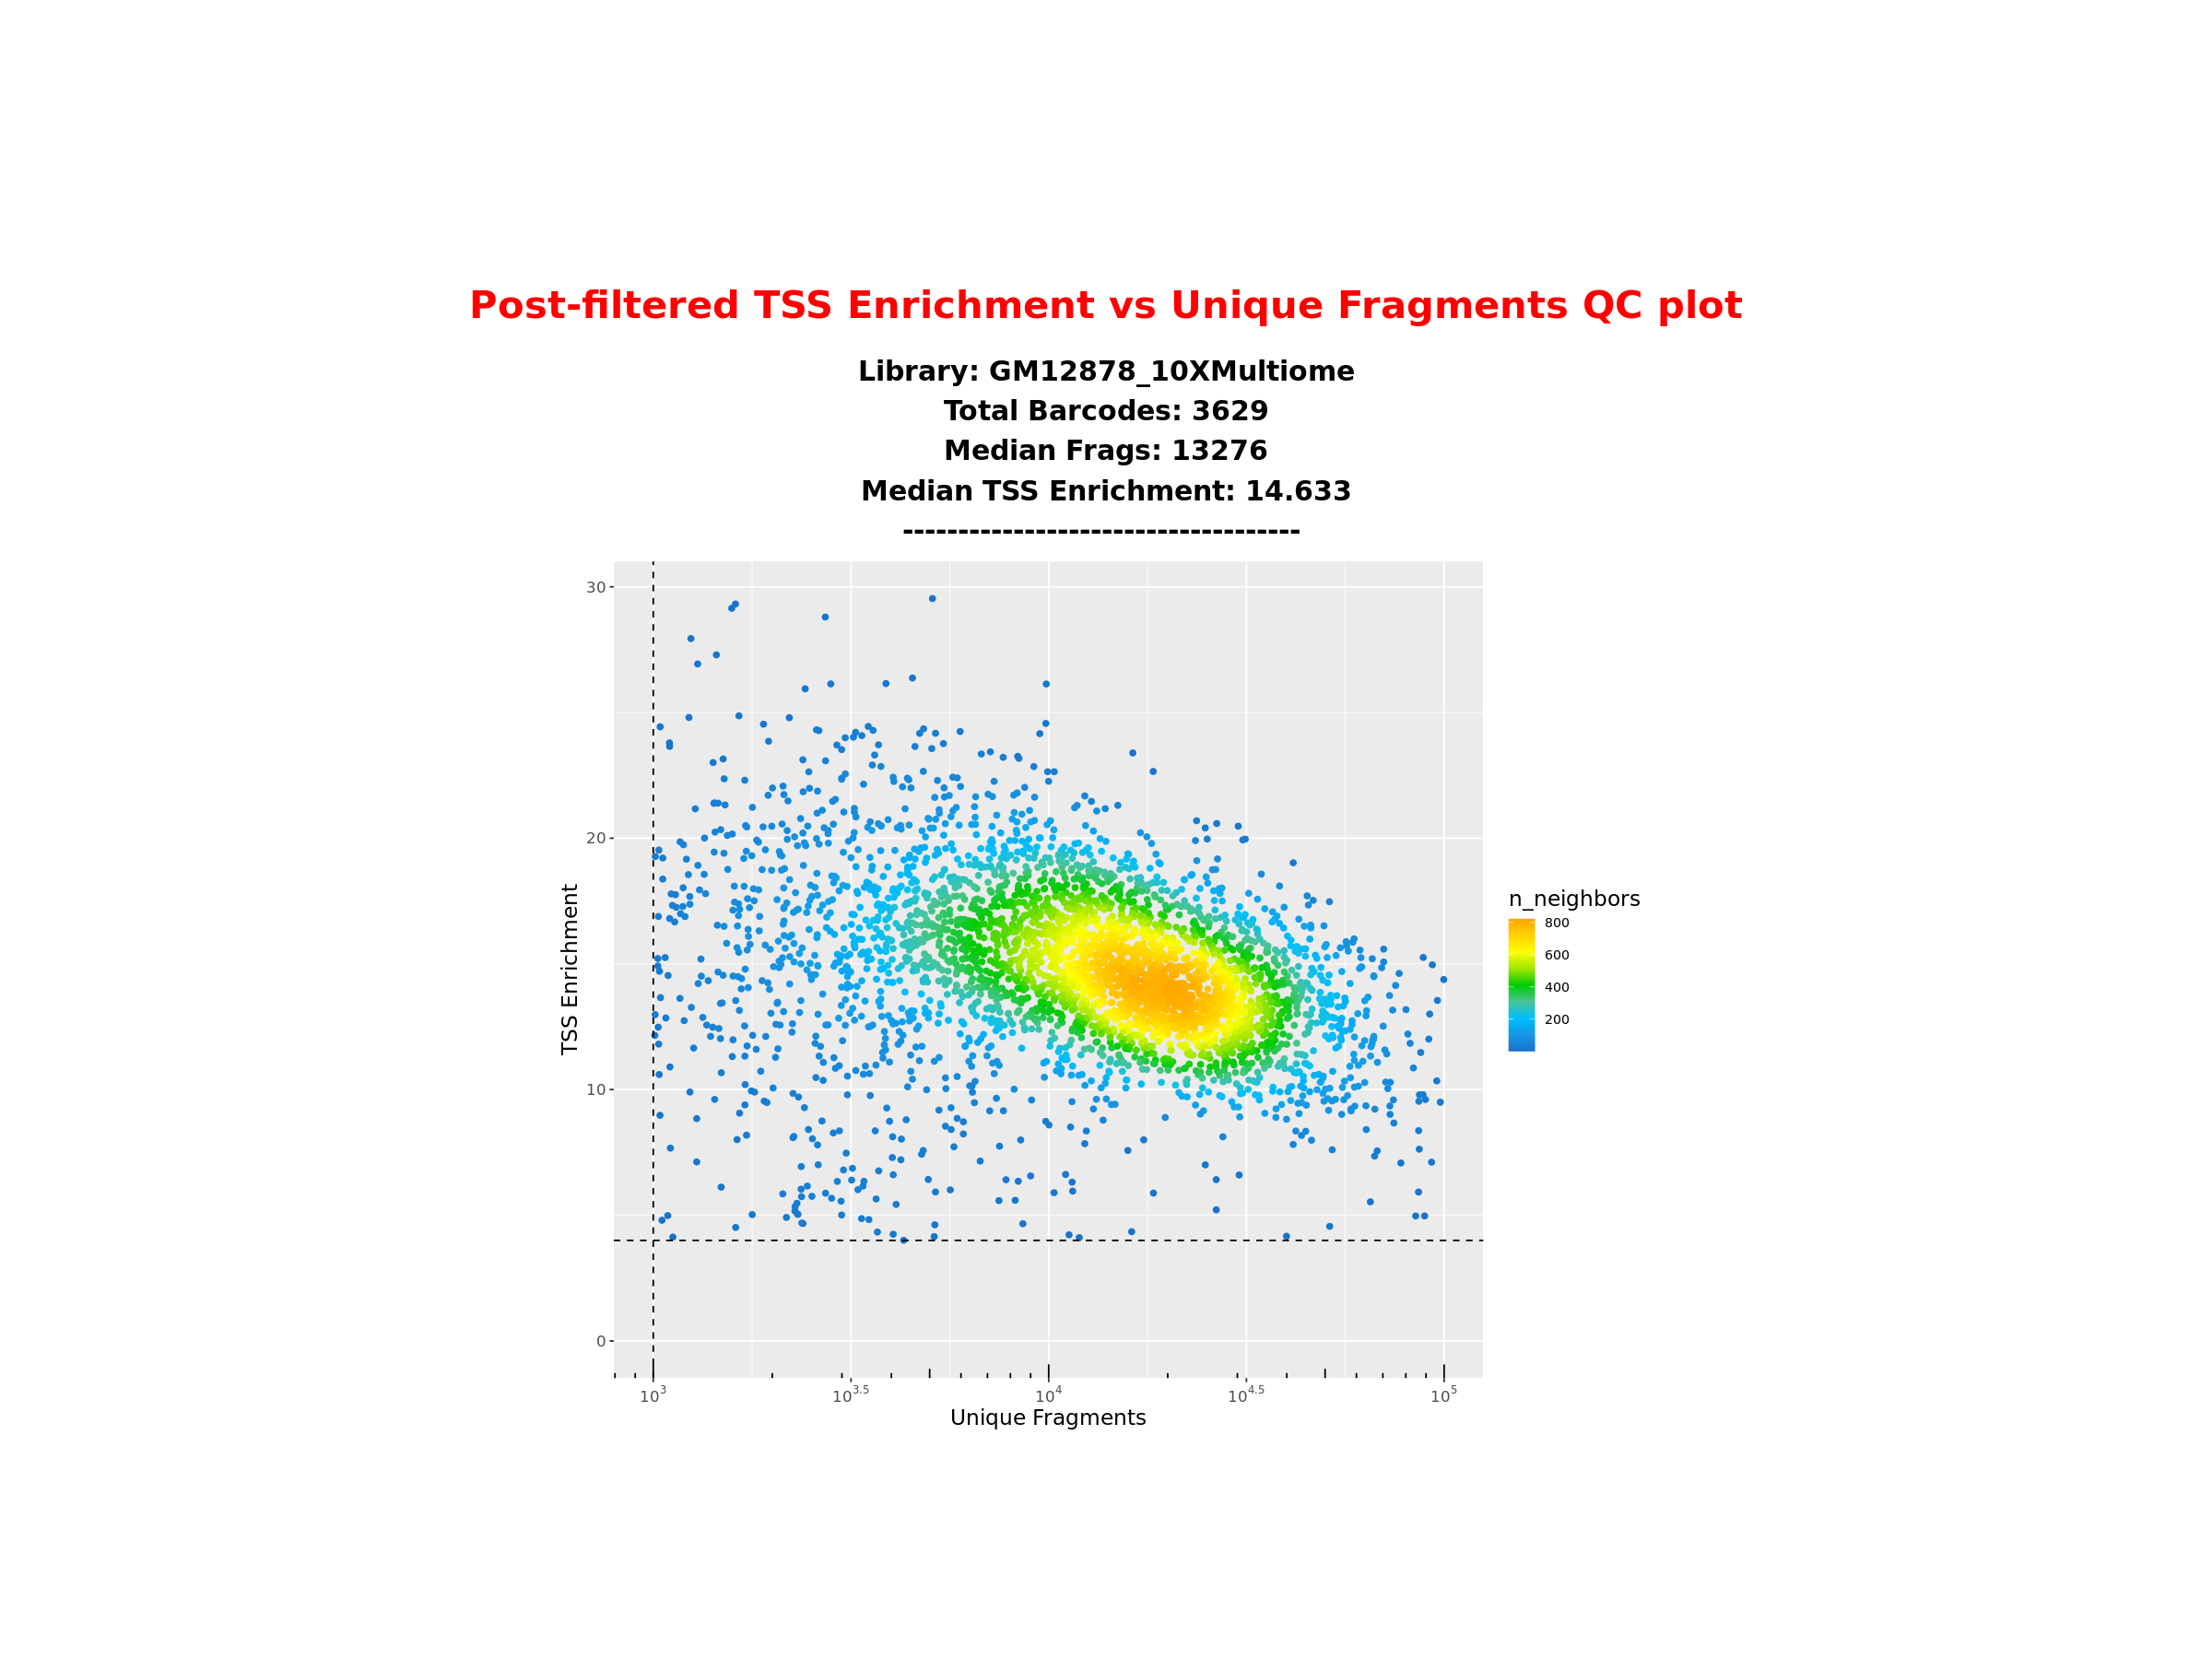

In [12]:
# Post-filtered TSS Enrichment vs Unique Fragments QC plot    
df <- as.data.frame(getCellColData(proj, select = c("nFrags", "TSSEnrichment")))
                                                                                                      
obj = ggplot(data=df, aes(x = nFrags, y = TSSEnrichment)) + 
            geom_pointdensity(method = "default") +
            scale_colour_gradientn(colors = paletteContinuous(set = "sambaNight")) +
            scale_x_continuous(trans = "log10", breaks = scales::trans_breaks("log10", function(x) 10^x), labels = scales::trans_format("log10", scales::math_format(10^.x))) +
            expand_limits(x = min(df$nFrags), y = 0) + 
            geom_hline(yintercept = min_tss, lty = "dashed") + 
            geom_vline(xintercept = min_frags, lty = "dashed") +
            xlab(label ="Unique Fragments") + 
            ylab(label = "TSS Enrichment") + 
            annotation_logticks(sides = "b") +
            labs(fill="density") +
            theme(axis.title=element_text(size=14), axis.text=element_text(size=10), legend.title=element_text(size=14), legend.text=element_text(size=8.5))
        
tg <- textGrob('Post-filtered TSS Enrichment vs Unique Fragments QC plot', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                        "Total Barcodes: ", nCells(proj), "\n", 
                        "Median Frags: ", median(proj$nFrags), "\n", 
                        "Median TSS Enrichment: ", median(proj$TSSEnrichment), "\n", 
                        "------------------------------------ \n"), 
                        gp = gpar(fontsize = 18, fontface = 'bold'))
plot_list = list(obj)
obj = create_plot(plot_list, tg, sg,heights=unit(c(1.5,1.5,8), rep("in",3)), width = 10)
grid.draw(obj)
printPNG(name = "postfiltered_tss_by_uniq_frags", plotObject = obj, papermill = papermill, wf = 11, hf = 12)
            

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-393518abbbb4-Date-2023-07-27_Time-16-03-48.413019.log
If there is an issue, please report to github with logFile!

2023-07-27 16:03:48.716941 : GM12878_10XMultiome Computing FragmentSizes (1 of 1)!, 0.005 mins elapsed.

2023-07-27 16:04:15.899061 : GM12878_10XMultiome Finished Computing FragmentSizes (1 of 1)!, 0.458 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-393518abbbb4-Date-2023-07-27_Time-16-03-48.413019.log



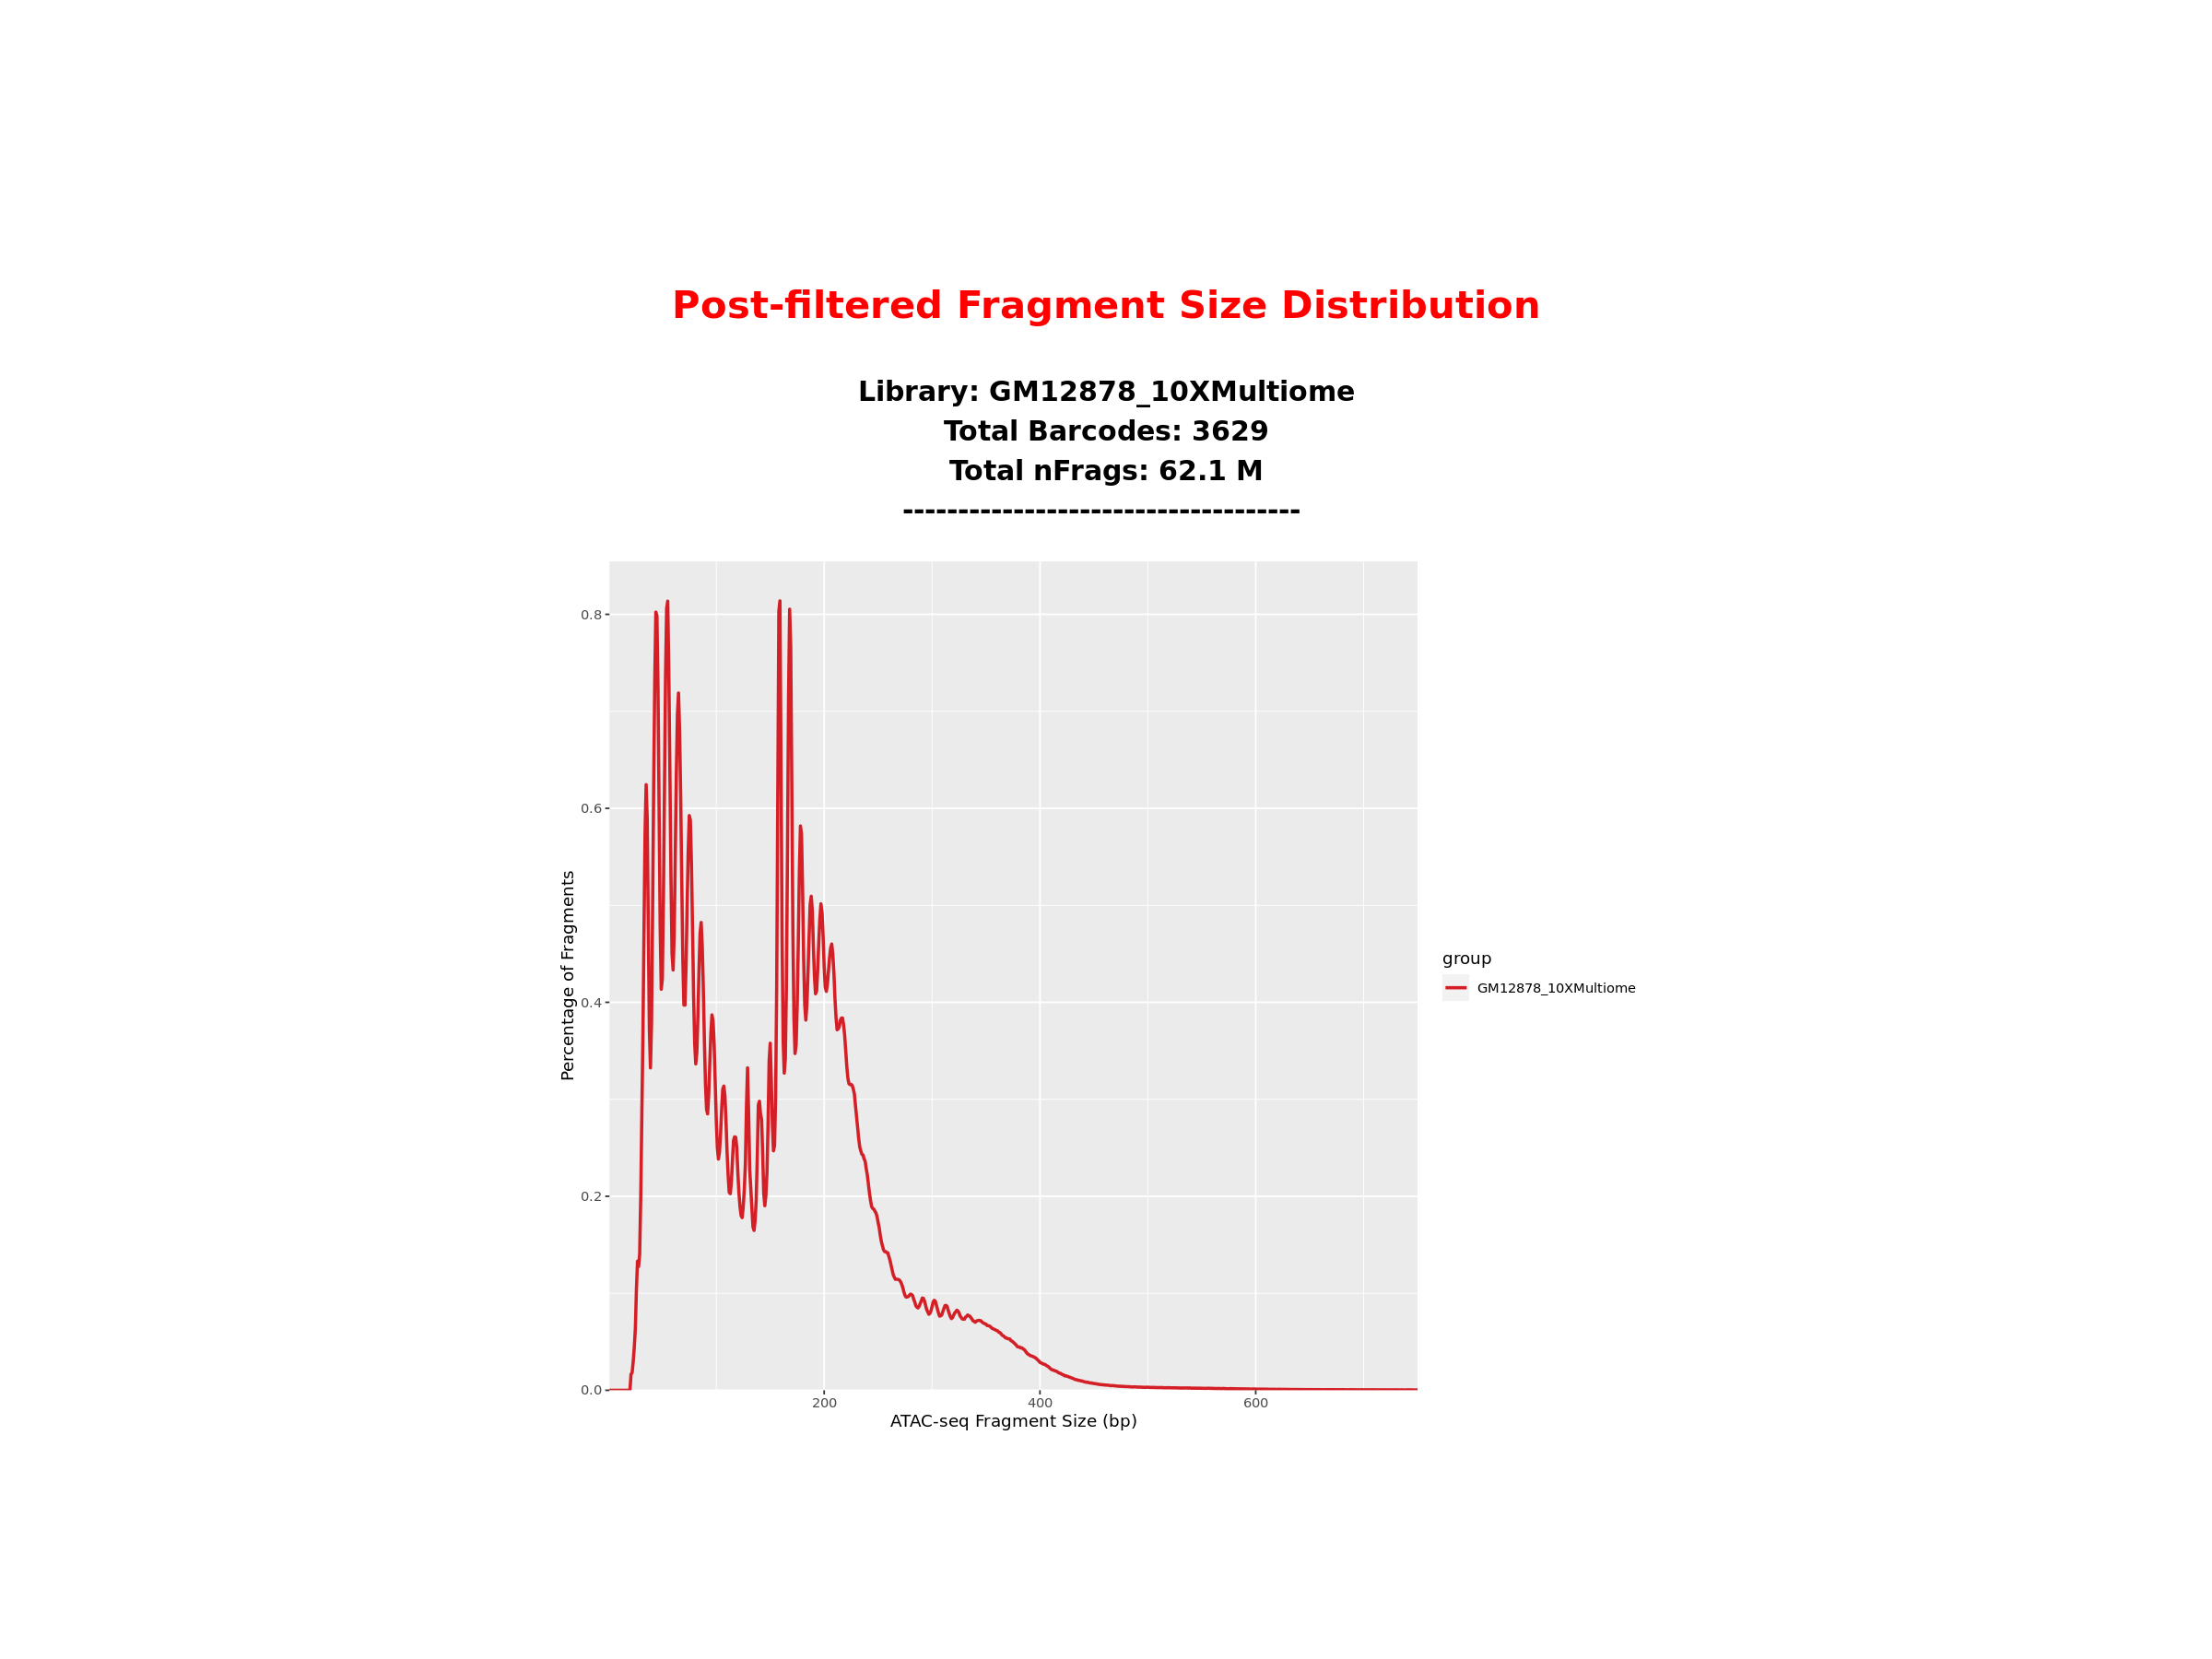

In [13]:
# Post-filtered Fragment Size Distribution plot

obj = plotFragmentSizes(ArchRProj = proj) +
        theme_gray()
            
tg <- textGrob('Post-filtered Fragment Size Distribution', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                        "Total Barcodes: ", nCells(proj), "\n", 
                        "Total nFrags: ", paste(format(round(sum(proj$nFrags) / 1e6, 1), trim = TRUE), "M"), "\n", 
                        "------------------------------------ \n"), 
                        gp = gpar(fontsize = 18, fontface = 'bold'))
plot_list = list(obj)
obj = create_plot(plot_list, tg, sg,heights=unit(c(1.5,1.5,8), rep("in",3)), width = 10)
grid.draw(obj)
printPNG(name = "postfiltered_frag_size_dist", plotObject = obj, papermill = papermill, wf = 11, hf = 12)


In [14]:
#Calculate doublet scores
proj <- addDoubletScores(
                input = proj,
                k = doublet_k,
                knnMethod = doublet_knn_method,
                LSIMethod = lsi_method)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-39357d655079-Date-2023-07-27_Time-16-04-25.825083.log
If there is an issue, please report to github with logFile!

2023-07-27 16:04:25.914762 : Batch Execution w/ safelapply!, 0 mins elapsed.

2023-07-27 16:04:25.923407 : GM12878_10XMultiome (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

GM12878_10XMultiome (1 of 1) : UMAP Projection R^2 = 0.98292

GM12878_10XMultiome (1 of 1) : UMAP Projection R^2 = 0.98292





ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-39357d655079-Date-2023-07-27_Time-16-04-25.825083.log



In [15]:
getAvailableMatrices(proj)

[1] "GeneScoreMatrix" "TileMatrix"

In [16]:
## filter doublets
proj <- filterDoublets(ArchRProj = proj) 

Filtering 131 cells from ArchRProject!

	GM12878_10XMultiome : 131 of 3629 (3.6%)



In [17]:
### Dimesionality reduction and Clustering

## dimensionality reduction via iterative LSI
proj <- addIterativeLSI(ArchRProj = proj, useMatrix = iter_LSI_matrix, name = "IterativeLSI")

## add clusters
proj <- addClusters(input = proj, reducedDims = "IterativeLSI")

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-393552f18a6b-Date-2023-07-27_Time-16-08-46.041981.log
If there is an issue, please report to github with logFile!

2023-07-27 16:08:46.307546 : Computing Total Across All Features, 0.001 mins elapsed.

2023-07-27 16:08:47.511188 : Computing Top Features, 0.021 mins elapsed.

###########
2023-07-27 16:08:49.485389 : Running LSI (1 of 2) on Top Features, 0.054 mins elapsed.
###########

2023-07-27 16:08:49.509475 : Creating Partial Matrix, 0.054 mins elapsed.

2023-07-27 16:09:03.380919 : Computing LSI, 0.286 mins elapsed.

2023-07-27 16:09:37.549783 : Identifying Clusters, 0.855 mins elapsed.

2023-07-27 16:09:43.673556 : Identified 6 Clusters, 0.957 mins elapsed.

2023-07-27 16:09:43.686755 : Saving LSI Iteration, 0.957 mins elapsed.



2023-07-27 16:10:00.118759 : Creating Cluster Matrix on the total Group Features, 1.231 mins elapsed.

2023-07-27 16:10:44.152942 : Computing Variable Features, 1.965 mins elapsed.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3498
Number of edges: 142954

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7271
Number of communities: 7
Elapsed time: 0 seconds


2023-07-27 16:11:30.404483 : Testing Outlier Clusters, 0.096 mins elapsed.

2023-07-27 16:11:30.411855 : Assigning Cluster Names to 7 Clusters, 0.096 mins elapsed.

2023-07-27 16:11:30.499629 : Finished addClusters, 0.098 mins elapsed.



In [18]:
### Add UMAP

proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI")

16:12:39 UMAP embedding parameters a = 0.7669 b = 1.223

16:12:39 Read 3498 rows and found 30 numeric columns

16:12:39 Using Annoy for neighbor search, n_neighbors = 40

16:12:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:12:39 Writing NN index file to temp file /tmp/RtmpYxpxWI/file3935adf8f0c

16:12:39 Searching Annoy index using 28 threads, search_k = 4000

16:12:40 Annoy recall = 100%

16:12:42 Commencing smooth kNN distance calibration using 28 threads
 with target n_neighbors = 40

16:12:43 Initializing from normalized Laplacian + noise (using irlba)

16:12:43 Commencing optimization for 500 epochs, with 214950 positive edges

16:13:00 Optimization finished

16:13:00 Creating temp model dir /tmp/RtmpYxpxWI/dir393521efa643

16:13:00 Creating dir /tmp/RtmpY

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-39356d5c47ad-Date-2023-07-27_Time-16-13-24.629404.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-39356d5c47ad-Date-2023-07-27_Time-16-13-24.629404.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-39357c0acdcc-Date-2023-07-27_Time-16-13-26.705708.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-39357c0acdcc-Date-2023-07-27_Time-16-13-26.705708.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-39354a799db1-Date-2023-07-27_Time-16-13-28.727826.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-3

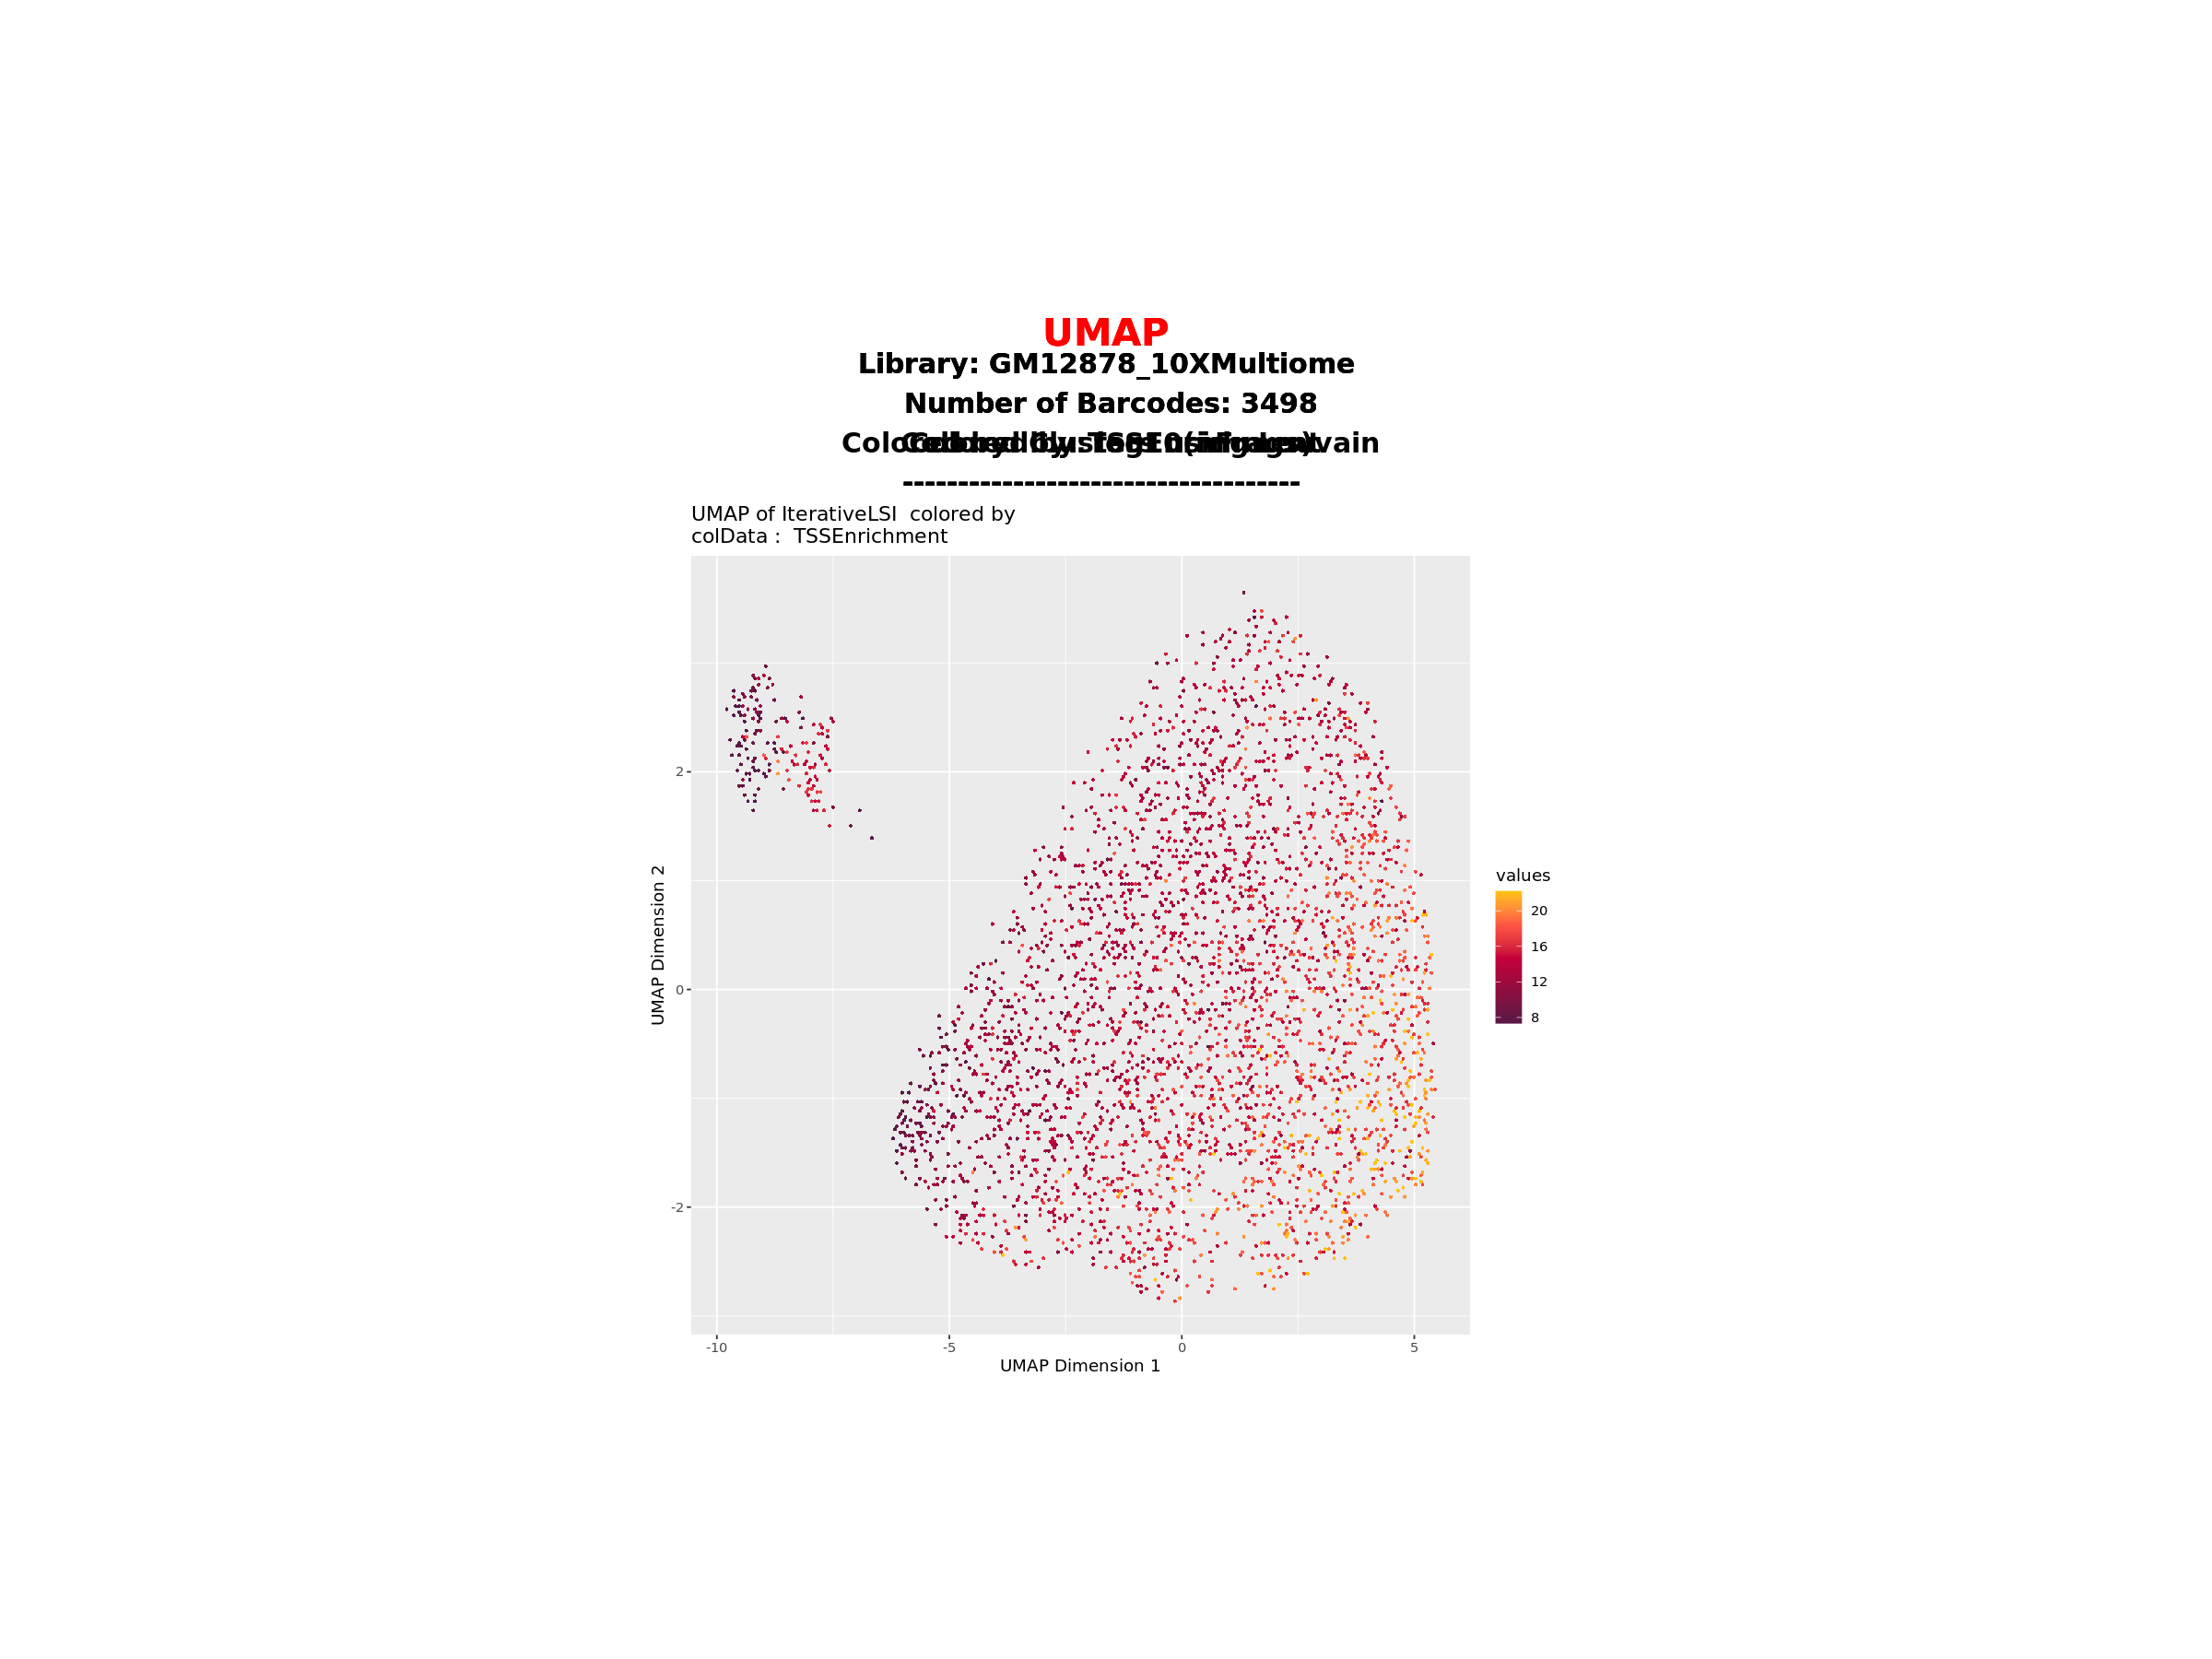

In [19]:
### Plot UMAP - Clusters
obj <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP") + 
                geom_point(size = 0.2)+
                theme_gray()  
tg <- textGrob('UMAP', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                        " Number of Barcodes: ", nCells(proj),"\n", 
                        " Colored by: Clusters using Louvain\n", 
                        "------------------------------------ \n"), 
                        gp = gpar(fontsize = 18, fontface = 'bold'))

plot_list = list(obj)
        
obj = create_plot(plot_list, tg, sg, heights=unit(c(1,1,8), rep("in",3)), width = 10)
grid.draw(obj)
    
printPNG('umap_clusters', obj, papermill, wf = 11, hf = 12)


### Plot UMAP - nFrags
proj$lognFrags = log10(proj$nFrags)
obj <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "lognFrags", embedding = "UMAP", 
                             pal = ArchRPalettes$purpleOrange) + 
                geom_point(size = 0.2)+
                theme_gray()
tg <- textGrob('UMAP', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                        " Number of Barcodes: ", nCells(proj),"\n", 
                        " Colored by: log10(nFrags)\n", 
                        "------------------------------------ \n"), 
                        gp = gpar(fontsize = 18, fontface = 'bold'))

plot_list = list(obj)
        
obj = create_plot(plot_list, tg, sg, heights=unit(c(1,1,8), rep("in",3)), width = 10)
grid.draw(obj)
    
printPNG('umap_num_frags', obj, papermill, wf = 11, hf = 12)


### Plot UMAP - TSS Enrichment
obj <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "TSSEnrichment", embedding = "UMAP",
                            pal = ArchRPalettes$purpleOrange) + 
                geom_point(size = 0.2)+
                theme_gray()  
tg <- textGrob('UMAP', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                        " Number of Barcodes: ", nCells(proj),"\n", 
                        " Colored by: TSSEnrichment\n", 
                        "------------------------------------ \n"), 
                        gp = gpar(fontsize = 18, fontface = 'bold'))

plot_list = list(obj)
        
obj = create_plot(plot_list, tg, sg, heights=unit(c(1,1,8), rep("in",3)), width = 10)
grid.draw(obj)
    
printPNG('umap_tss_score', obj, papermill, wf = 11, hf = 12)





In [20]:
### Plot UMAP - FRIP
obj <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "FRIP", embedding = "UMAP",
                            pal = ArchRPalettes$purpleOrange) + 
                geom_point(size = 0.2)+
                theme_gray()  
tg <- textGrob('UMAP', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                        " Number of Barcodes: ", nCells(proj),"\n", 
                        " Colored by: FRIP\n", 
                        "------------------------------------ \n"), 
                        gp = gpar(fontsize = 18, fontface = 'bold'))

plot_list = list(obj)
        
obj = create_plot(plot_list, tg, sg, heights=unit(c(1,1,8), rep("in",3)), width = 10)
grid.draw(obj)
    
printPNG('umap_frip', obj, papermill, wf = 11, hf = 12)



ArchR logging to : ArchRLogs/ArchR-plotEmbedding-39354d4682f2-Date-2023-07-27_Time-16-13-43.446534.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData



ERROR: Error in value[[3L]](cond): select Not Found in Colnames of cellColData:
[1m[33mError[39m in `dplyr::mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `tmpNewCol123 = eval(parse(text = select[x]))`.
[1mCaused by error:[22m
[33m![39m object 'FRIP' not found



ArchR logging to : ArchRLogs/ArchR-plotEmbedding-393515cb2e0a-Date-2023-07-27_Time-16-13-48.417834.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-393515cb2e0a-Date-2023-07-27_Time-16-13-48.417834.log



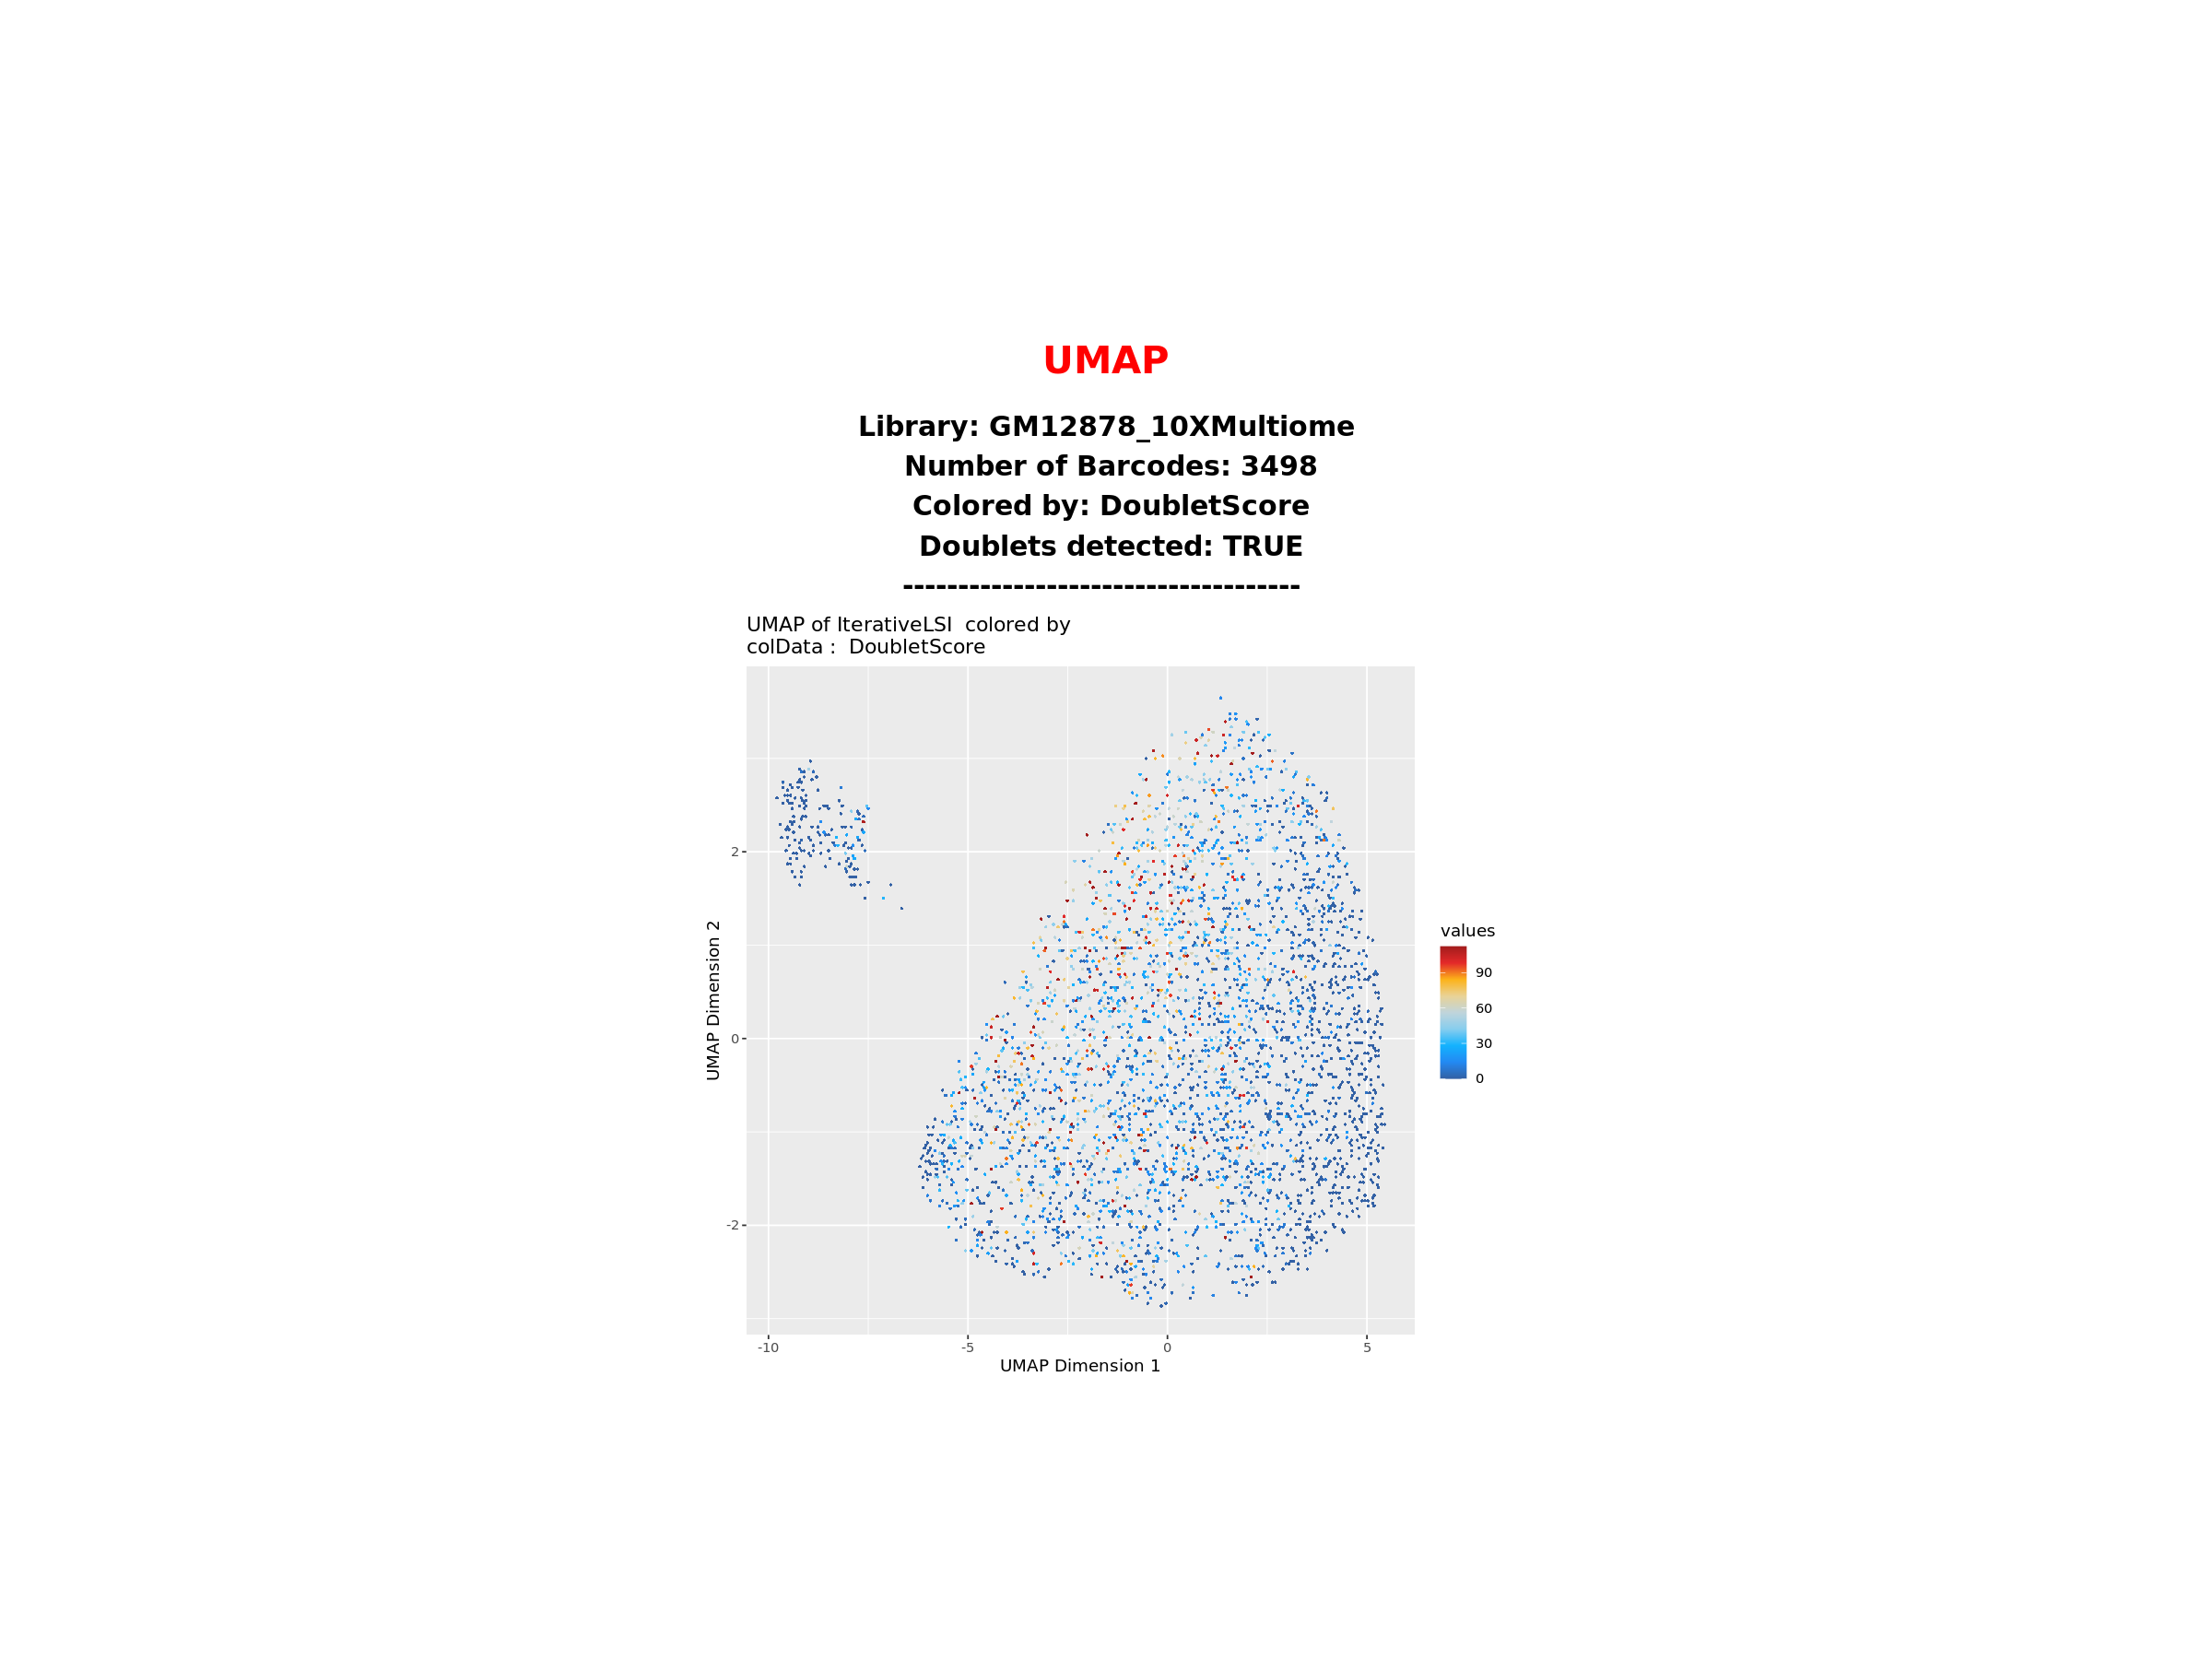

In [21]:
doub_flag = FALSE
proj$DoubletScore[is.na(proj$DoubletScore)] <- 0
if (sum(proj$DoubletScore) > 0){
        doub_flag = TRUE}
obj <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "DoubletScore", embedding = "UMAP") + 
                    geom_point(size = 0.1)+
                    theme_gray()  
tg <- textGrob('UMAP', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                            " Number of Barcodes: ", nCells(proj),"\n", 
                            " Colored by: DoubletScore\n", 
                            " Doublets detected: ", doub_flag ,"\n", 
                            "------------------------------------ \n"), 
                            gp = gpar(fontsize = 18, fontface = 'bold'))

plot_list = list(obj)

obj = create_plot(plot_list, tg, sg, heights=unit(c(1.5,1.5,7), rep("in",3)), width = 10)
grid.draw(obj)

printPNG('umap_doublets', obj, papermill, wf = 11, hf = 12)


In [22]:
#Extract marker genes
## single core worked, multicore breaks 

markersGS <- getMarkerFeatures(
    ArchRProj = proj, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = marker_features_test
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-39353b9109d0-Date-2023-07-27_Time-16-13-57.760283.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2023-07-27 16:13:57.986582 : Matching Known Biases, 0.002 mins elapsed.

2023-07-27 16:14:00.060261 : Computing Pairwise Tests (1 of 7), 0.036 mins elapsed.

Pairwise Test C1 : Seqnames chr1

Pairwise Test C1 : Seqnames chr10

Pairwise Test C1 : Seqnames chr11

Pairwise Test C1 : Seqnames chr12

Pairwise Test C1 : Seqnames chr13

Pairwise Test C1 : Seqnames chr14

Pairwise Test C1 : Seqnames chr15

Pairwise Test C1 : Seqnames chr16

Pairwise Test C1 : Seqnames chr17

Pairwise Test C1 : Seqnames chr18

Pairwise Test C1 : Seqnames chr19

Pairwise Test C1 : Seqnames chr2

Pairwise Test C1 : Seqnames chr20

Pairwise Test C1 : Seqnames chr21

Pairwise Test C1 : Seqnames chr22

Pairwise Test C1 : Seqnames chr3

Pairwise Test C1 : Seqnames chr4

Pairwise Test C1 : Seqnames chr5

Pairwise Test

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-39351400db80-Date-2023-07-27_Time-16-18-33.081275.log
If there is an issue, please report to github with logFile!

Printing Top Marker Genes:

C1:

	FAM87B, TTLL10, C1QTNF12, TNFRSF14, LOC100996583, LRRC47, LINC01346, TNFRSF9, TNFRSF8, TMEM51, C1orf195, ZBTB17, PADI2, PADI1, ARHGEF10L

C2:

	FAM87B, TTLL10, C1QTNF12, TNFRSF14, LOC100996583, CCDC27, SMIM1, LRRC47, LINC01346, TNFRSF9, TNFRSF8, TMEM51, C1orf195, ZBTB17, LOC105376805

C3:

	RGSL1, PRG2, SLC43A3, CD5, MIR6755, CMKLR1, LCT, MYO1B, HLA-DRB5, TTC39A, LINC01686, SLC45A3, SAA1, MIR1343, ZC3H12C

C4:

	AGBL4, CHRM3, PRKG1, PCDH15, CTNNA3, NRG3, ATRNL1, DOCK1, NELL1, ANO2, LINC00939, NPAS3, TTC6, GABRG3, RBFOX1

C5:

	SIVA1, ABCA7, KRI1, CDKN2D, ETV2, COX6B1, GMFG, APOBEC3C, APOBEC3D, TRABD, NDUFAF3, MDC1, TUBB, SLC2A8, VPS37B

C6:

	CCDC27, SMIM1, MIR3115, ASAP3, LOC284632, NCMAP, MRPL37, MIR3117, TCTEX1D1, COL24A1, ODF2L, KCNA3, LOC100996263, TENT5C, GDAP2

C7:

	LOC105376805,

 [1] "FAM87B"       "TTLL10"       "C1QTNF12"     "TNFRSF14"     "LOC100996583"
 [6] "RGSL1"        "PRG2"         "SLC43A3"      "CD5"          "MIR6755"     
[11] "AGBL4"        "CHRM3"        "PRKG1"        "PCDH15"       "CTNNA3"      
[16] "SIVA1"        "ABCA7"        "KRI1"         "CDKN2D"       "ETV2"        
[21] "CCDC27"       "SMIM1"        "MIR3115"      "ASAP3"        "LOC284632"   
[26] "LOC105376805" "RNASE12"      "OR6S1"        "LINC01585"    "NXPE4"       


Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-39351400db80-Date-2023-07-27_Time-16-18-33.081275.log



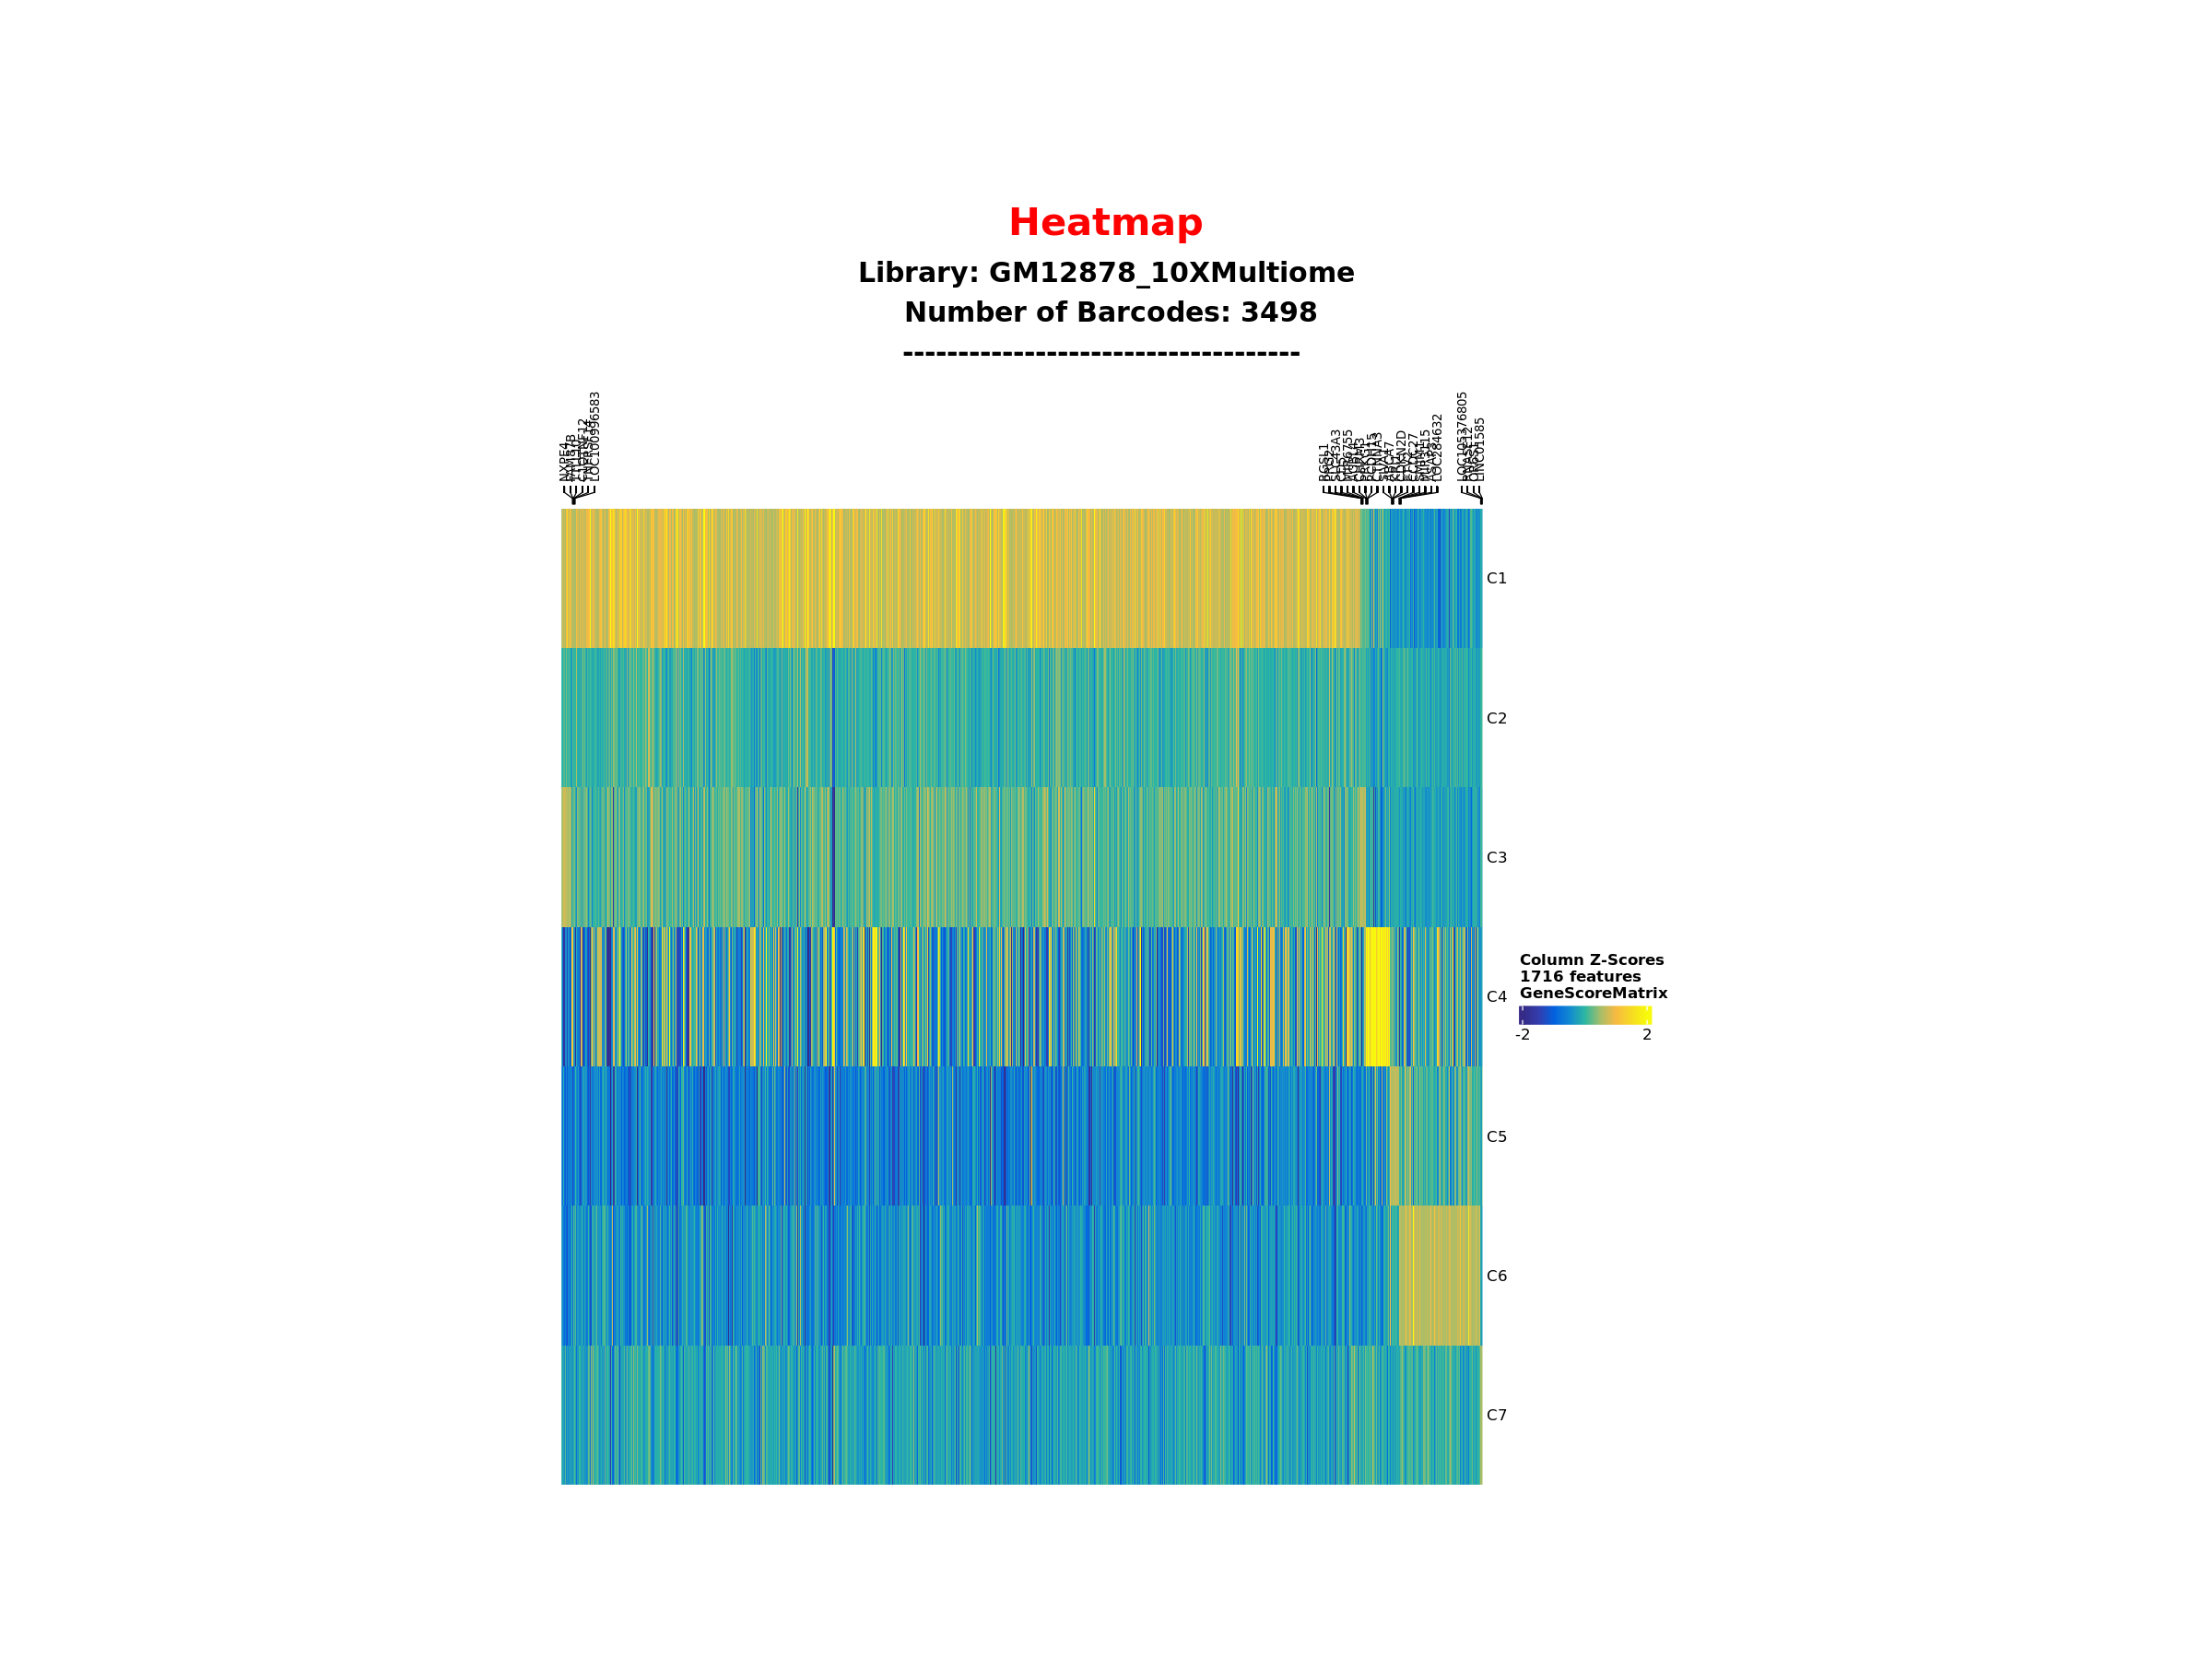

In [23]:
#Plot heatmap of upregulated genes in clusters

hm <- plotMarkerHeatmap(markersGS, transpose = heatmap_transpose, nLabel = heatmap_label_n, 
                                 cutOff = heatmap_cutoff, plotLog2FC = TRUE) 
obj = grid.grabExpr(draw(hm))
tg <- textGrob('Heatmap', gp = gpar(fontsize = 25, fontface = 'bold', col = 'red'))
sg <- textGrob(paste0("Library: ", prefix, "\n", 
                        " Number of Barcodes: ", nCells(proj),"\n", 
                        "------------------------------------ \n"), 
                        gp = gpar(fontsize = 18, fontface = 'bold'))

plot_list = list(obj)
        
obj = create_plot(plot_list, tg, sg, heights=unit(c(1,1,10), rep("in",3)), width = 10)
grid.draw(obj)
    
printPNG('heatmap', obj, papermill, wf = 11, hf = 12)

In [32]:
library(hdf5r)


Attaching package: ‘hdf5r’


The following object is masked from ‘package:rtracklayer’:

    values


The following object is masked from ‘package:rhdf5’:

    h5version


The following object is masked from ‘package:SummarizedExperiment’:

    values


The following object is masked from ‘package:GenomicRanges’:

    values


The following object is masked from ‘package:S4Vectors’:

    values




In [33]:
#Create final output files

# files2zip <- dir(plot_filename, full.names = TRUE)
# zip(zipfile = paste0(plot_filename,'.zip'), files = files2zip)

# saveRDS(proj, file = paste0(prefix,".atac.archr.filtered_project.",genome,".rds"))
    
##### this below block of code doesn't work since write_dgCMatrix_h5 
##### function is not there. For that the package required 
##### is "hdf5r" -- installing that was failing constantly

#######################################################################################################################
mtx = getMatrixFromProject(ArchRProj = proj,useMatrix = "GeneScoreMatrix")
rownames(mtx) = proj@peakSet$idx
write_dgCMatrix_h5(assay(mtx), 
                cols_are = "barcodes", 
                h5_target = paste0(prefix,".atac.archr.filtered_matrix.",genome,".h5"), 
                ref_name = prefix)
rm(mtx)

######################################################################################################################
    
# meta = proj@cellColData
# meta$barcodes = rownames(meta)
        
# #write metadata tsv 
# write.table(x = meta, file =  paste0(prefix,".atac.archr.barcode_metadata.",genome,".tsv"), sep = "\t", quote = F, row.names = F)


ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-3935431a91fb-Date-2023-07-27_Time-17-13-01.798348.log
If there is an issue, please report to github with logFile!

2023-07-27 17:15:46.366624 : Organizing colData, 2.743 mins elapsed.

2023-07-27 17:15:46.43805 : Organizing rowData, 2.744 mins elapsed.

2023-07-27 17:15:46.442426 : Organizing rowRanges, 2.744 mins elapsed.

2023-07-27 17:15:46.452709 : Organizing Assays (1 of 1), 2.744 mins elapsed.

2023-07-27 17:15:46.497175 : Constructing SummarizedExperiment, 2.745 mins elapsed.

2023-07-27 17:15:47.682261 : Finished Matrix Creation, 2.765 mins elapsed.



ERROR: Error in write_dgCMatrix_h5(assay(mtx), cols_are = "barcodes", h5_target = paste0(prefix, : could not find function "write_dgCMatrix_h5"
